<a href="https://colab.research.google.com/github/TheSanchouz/diabetes_patient_readmission/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imbalanced-learn
!pip install faiss-cpu
!pip install category_encoders

     |████████████████████████████████| 7.9MB 5.6MB/s 
     |████████████████████████████████| 81kB 3.7MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import sklearn
import imblearn

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Diabetes 130 US hospitals for years 1999-2008

Набор данных представляет сводку клинической помощи за 10 лет (1999-2008) в 130 больницах США и в интегрированных сетях оказания медицинской помощи.

In [3]:
url = 'https://raw.githubusercontent.com/TheSanchouz/diabetes_patient_readmission/main/diabetic_data.csv'
df = pd.read_csv(url)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Датасет состоит из 101 766 записей и 50 признаков

In [4]:
df.shape

(101766, 50)

Посмотрим на наш набор данных, отобразив первые 10 записей (для удобства транспонируем таблицу)

In [5]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
encounter_id,2278392,149190,64410,500364,16680,35754,55842,63768,12522,15738
patient_nbr,8222157,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female
age,[0-10),[10-20),[20-30),[30-40),[40-50),[50-60),[60-70),[70-80),[80-90),[90-100)
weight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
admission_type,NaN,Emergency,Emergency,Emergency,Emergency,Urgent,Elective,Emergency,Urgent,Elective
discharge_disposition,Not Mapped,Discharged to home,Discharged to home,Discharged to home,Discharged to home,Discharged to home,Discharged to home,Discharged to home,Discharged to home,Discharged/transferred to SNF
admission_source,Physician Referral,Emergency Room,Emergency Room,Emergency Room,Emergency Room,Clinic Referral,Clinic Referral,Emergency Room,Transfer from a hospital,Transfer from a hospital
time_in_hospital,1,3,2,2,1,3,4,5,13,12


Данные состоят из числовых, и категориальных признаков, также имеютcя пропущенные значения (NaN)

# Описание данных

## Входные признаки
*   **encounter_ID** [числовой]: уникальный идентификатор приема
*   **patient_nbr** [числовой]: уникальный идентификатор пациента
*   **race** [категориальный]: расовая принадлежность (Caucasian, Asian, African American, Hispanic и др.)
*   **gender** [категориальный]: пол
*   **age** [категориальный]: возраст, сгруппирован в 10-летние интервалы ([0, 10), [10, 20), ...)
*   **weight** [категориальный]: вес в фунтах, сгруппирован в 25-фунтовые интервалы ([0, 25), [25, 50), ...)
*   **admission_type** [категориальный]: тип обращения
*   **discharge_disposition** [категориальный]: расположение пациента на момент выписки
*   **admission_source** [категориальный]: источник направления для приема или посещения
*   **time_in_hospital** [числовой]: кол-во дней проведенных в больнице, между поступлением и выпиской
*   **payer_code** [категориальный]: код плательщика (кто или что покрывает медицинские расходы)
*   **medical_specialty** [категориальный]: медицинская специальность принимающего врача
*   **num_lab_procedures** [числовой]: число лабораторных тестов, проведенных во время посещения
*   **num_procedures** [числовой]: число процедур (кроме лаб.тестов), выполненных во время посещения
*   **num_medications** [числовой]: кол-во назначенных препаратов во время посещения
*   **number_outpatient** [числовой]: ко-во амбулаторных посещений пациента в год, предшествующих обращению
*   **number_emergency** [числовой]: кол-во обращений пациента за неотложной помощью в год, предшествующих обращению
*   **number_inpatient** [числовой]: кол-во стационарных посещений пациента в год, предшествующих обращению
*   **diag_1** [категориальный]: первичный диагноз (кодируется первыми 3-мя цифрами ICD9 (МКБ9))
*   **diag_2** [категориальный]: вторичный диагноз (кодируется первыми 3-мя цифрами ICD9 (МКБ9))
*   **diag_3** [категориальный]: дополнительный вторичный диагноз (кодируется первыми 3-мя цифрами ICD9 (МКБ9))
*   **number_diagnoses** [числовой]: число диагнозов, введенных в систему
*   **max_glu_serum** [категориальный]: диапазон результата теста на глюкозу в сыворотке кроки
*   **A1Cresult** [категориальный]: диапазон результата теста A1C
*   **metformin, ..., pioglitazone** [категориальный]: 23 различных лекарств; признак указывает, был ли препарат прописан или было изменение дозировки
*   **change** [категориальный]: указывает, было ли изменение лекарств от диабета (дозировка или препарат)
*   **diabetesMed** [категориальный]: указывает, были ли прописаны лекарства от диабета

## Выходной признак
*   **readmitted** [категориальный]: повторная госпитализация







# Постановка задачи

Важно знать, будет ли пациент повторно госпитализирован (реадмиссия, readmission).

В этой базе данных у нас есть 3 разных выхода:

*   нет реадмиссии [NO]
*   реадмиссия менее чем через 30 дней [<30] (это не лучшая ситуация, потому что, возможно, лечение не было подходящим)
*   реадмиссия более чем через 30 дней [>30] (эта не так хорошо, однако причиной может быть состояние пациента)

Показатели реадмиссии все чаще используются в качестве критерия результатов в исследованиях медицинских услуг и в качестве критерия качества для систем здравоохранения. Как правило, более высокая частота повторных госпитализаций указывает на неэффективность лечения во время прошлых госпитализаций.

Сведем задачу к бинарной классификации, т.к. в первую очередь, наибольший интерес представляет ранняя реадмиссия:
*   нет реадмиссии или реадмиссия более чем через 30 дней [NO]
*   реадмиссия менее чем через 30 дней [YES]



In [6]:
df['readmitted'] = df['readmitted'].replace('<30', 'YES')
df['readmitted'] = df['readmitted'].replace('>30', 'NO')

# Анализ данных

Категоризуем признаки, имеющие тип 'object'

In [7]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type              object
discharge_disposition       object
admission_source            object
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

In [8]:
for col in df.select_dtypes(['object']):
    df[col] = df[col].astype('category')

In [9]:
df.dtypes

encounter_id                   int64
patient_nbr                    int64
race                        category
gender                      category
age                         category
weight                      category
admission_type              category
discharge_disposition       category
admission_source            category
time_in_hospital               int64
payer_code                  category
medical_specialty           category
num_lab_procedures             int64
num_procedures                 int64
num_medications                int64
number_outpatient              int64
number_emergency               int64
number_inpatient               int64
diag_1                      category
diag_2                      category
diag_3                      category
number_diagnoses               int64
max_glu_serum               category
A1Cresult                   category
metformin                   category
repaglinide                 category
nateglinide                 category
c

In [10]:
df.duplicated(subset=['patient_nbr']).value_counts()

False    71518
True     30248
dtype: int64

У некоторых пациентов в наборе данных было несколько встреч. Мы не можем считать их независимыми встречами, потому что возможно это будет смещать результаты в сторону тех пациентов, у которых было несколько встреч. Можно по разному решать этот вопрос. Будем использовать только первые встречи пациентов с несколькими обращениями.

In [11]:
# df.drop_duplicates(subset=['patient_nbr'], keep='first', inplace=True)

Также удалим "encounter_id" и "patient_nbr", поскольку это идентификаторы

In [12]:
df.drop(['encounter_id', 'patient_nbr'], axis=1, inplace=True)

In [13]:
df.shape

(101766, 48)

Выведем количественную информацию про числовые признаки

In [14]:
df.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


И для категориальных признаков тоже

In [15]:
df.describe(include=['category'])

,race,gender,age,weight,admission_type,discharge_disposition,admission_source,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,99493,101766,101766,3197,96475,98075,94985,61510,51817,101745,101408,100343,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,5,3,10,9,7,25,16,17,72,716,748,789,4,4,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,1,1,4,4,2,2,2,2,2,2,2
top,Caucasian,Female,[70-80),[75-100),Emergency,Discharged to home,Emergency Room,MC,InternalMedicine,428,276,250,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54708,26068,1336,53990,60234,57494,32439,14635,6862,6752,11555,96420,84748,81778,100227,101063,101680,96575,101765,89080,91116,101743,94438,95401,101458,101728,101763,101727,101766,101766,47383,101060,101753,101765,101764,101765,54755,78363,90409


При анализе статистики категориальных признаков, можно заметить, что признаки "examide", "citoglipton", "glimepiride-pioglitazone" состоят лишь из одного значения, а следовательно не несут какой-либо полезной информации, удалим их.


In [16]:
df.drop(['examide', 'citoglipton'], axis=1, inplace=True)
# df.drop(['examide', 'citoglipton', 'glimepiride-pioglitazone'], axis=1, inplace=True)


Также можно увидеть, что признаки "diag_1", "diag_2" и "diag_3" содержат большое кол-во уникальных значений (~750)

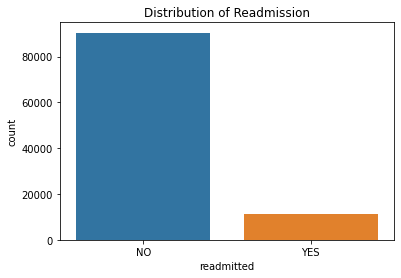

In [17]:
sns.countplot(x=df['readmitted']).set_title('Distribution of Readmission')
pass

Мы видим, что классы являются несбалансированными

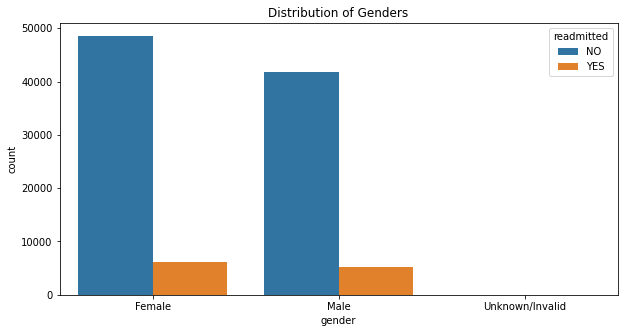

In [18]:
plt.figure(figsize=(10, 5))
sns.countplot(x=df['gender'], hue=df['readmitted']).set_title('Distribution of Genders')
pass

Заметно, что женщин в датасете было чуть больше, еще замечаем что есть невалидное значение (позже необходимо с этим разобраться)

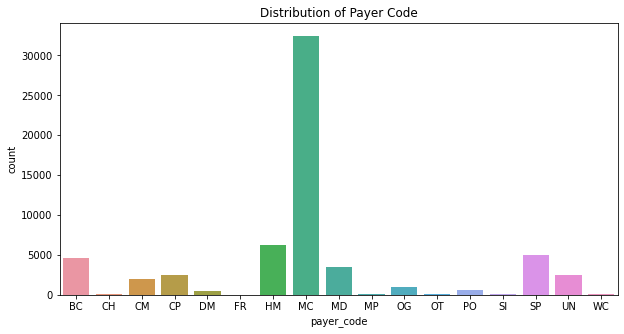

In [19]:
plt.figure(figsize=(10, 5))
sns.countplot(x=df['payer_code']).set_title('Distribution of Payer Code')
pass

Большинство пациентов оплачивали медуслуги по страховке (MC)

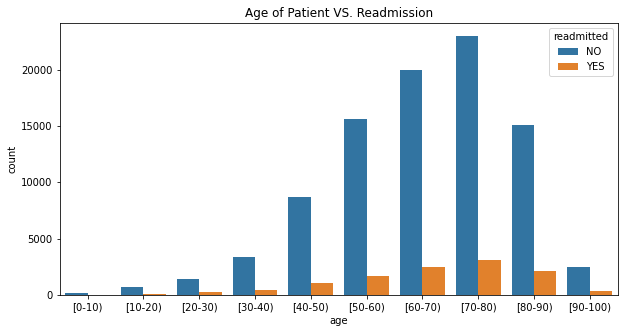

In [20]:
plt.figure(figsize=(10, 5))
sns.countplot(x=df['age'], hue=df['readmitted']).set_title('Age of Patient VS. Readmission')
pass

Из распределения возраста заметно, что большинство пациентов - люди в возрасте

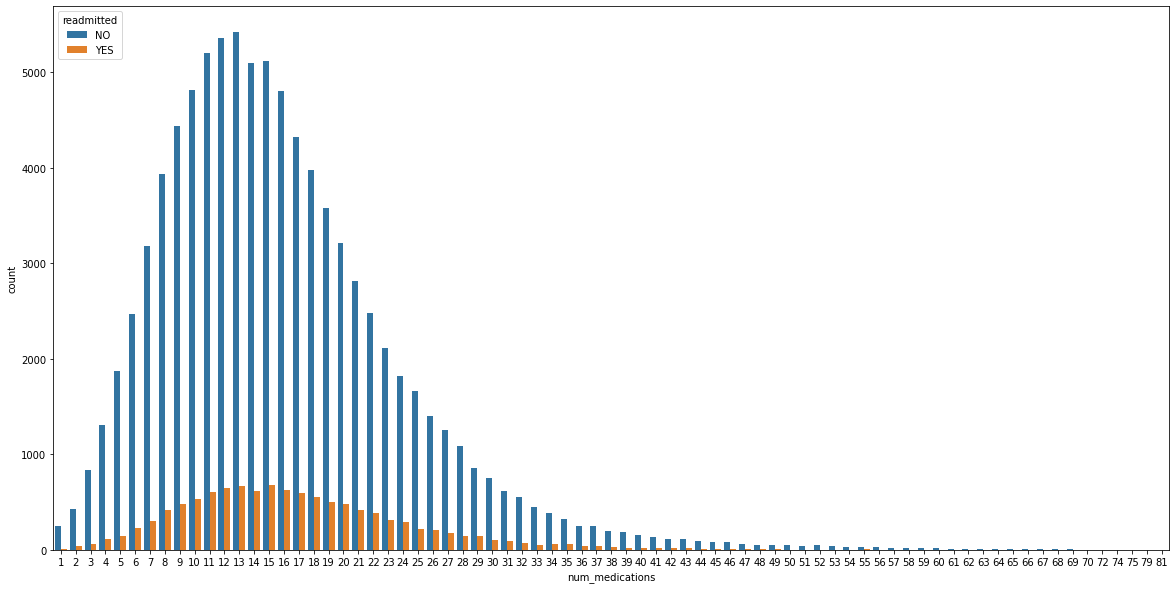

In [21]:
fig = plt.figure(figsize=(20, 10))
sns.countplot(x=df['num_medications'], hue=df['readmitted'])
pass

В среднем назначается около 13-14 препаратов

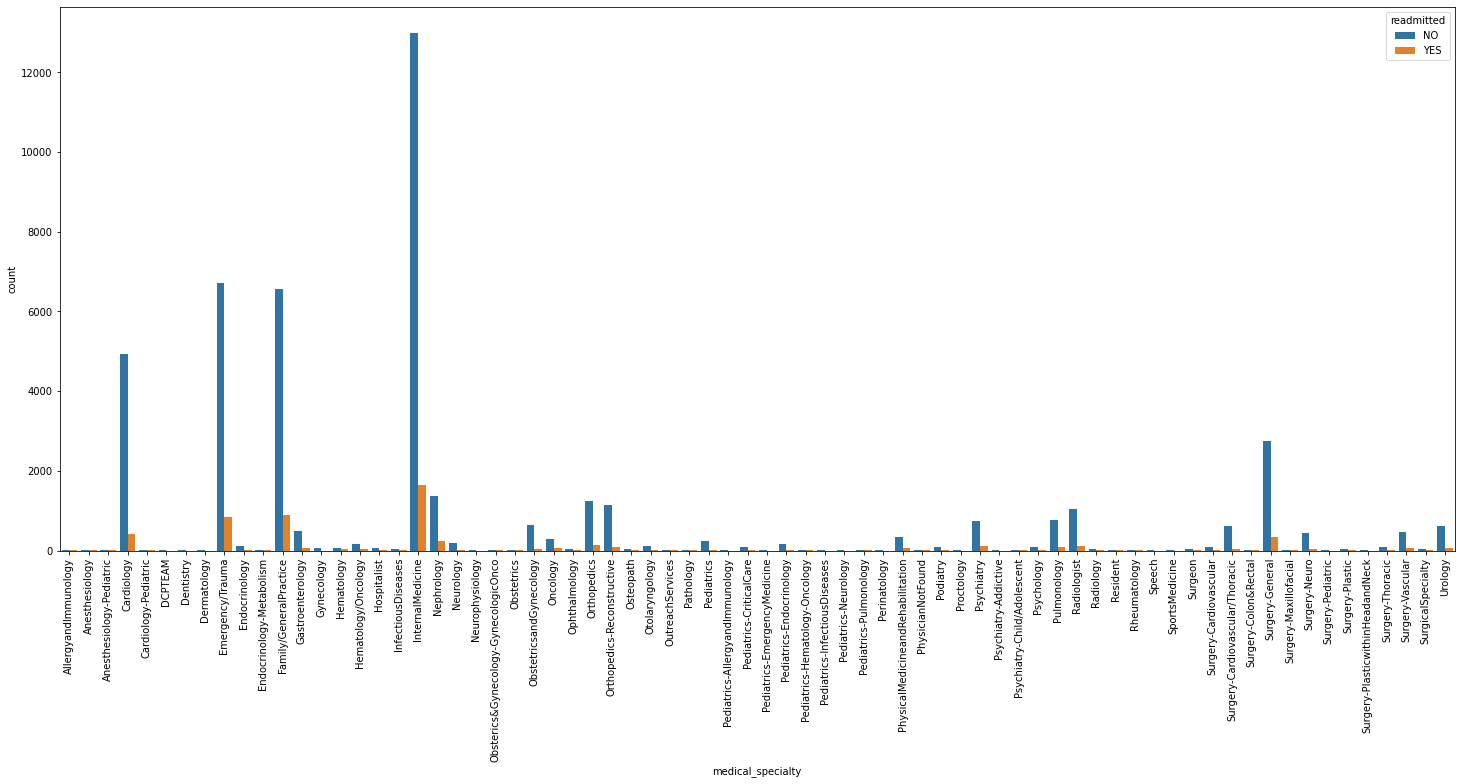

In [22]:
plt.figure(figsize=(25, 10))
chart = sns.countplot(x=df['medical_specialty'], hue=df['readmitted'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
pass

Большинство пациентов поступали в отделение\к врачам: терапия, неотложная помощь и травматология, семейный врач, кардиология 

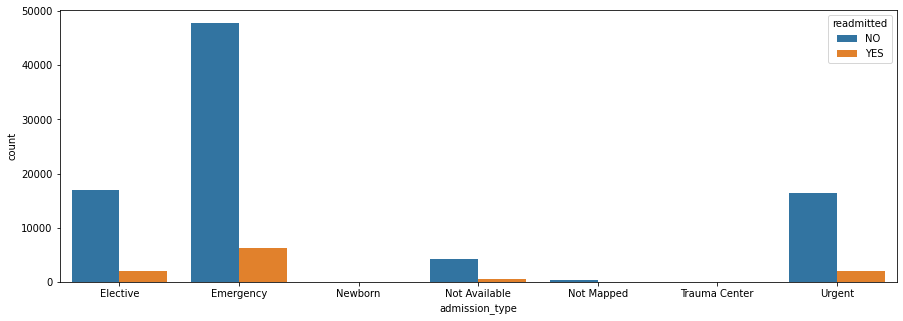

In [23]:
plt.figure(figsize=(15, 5))
chart = sns.countplot(x=df['admission_type'], hue=df['readmitted'])
pass

Большинство обращений было - неотложным, плановым и срочным

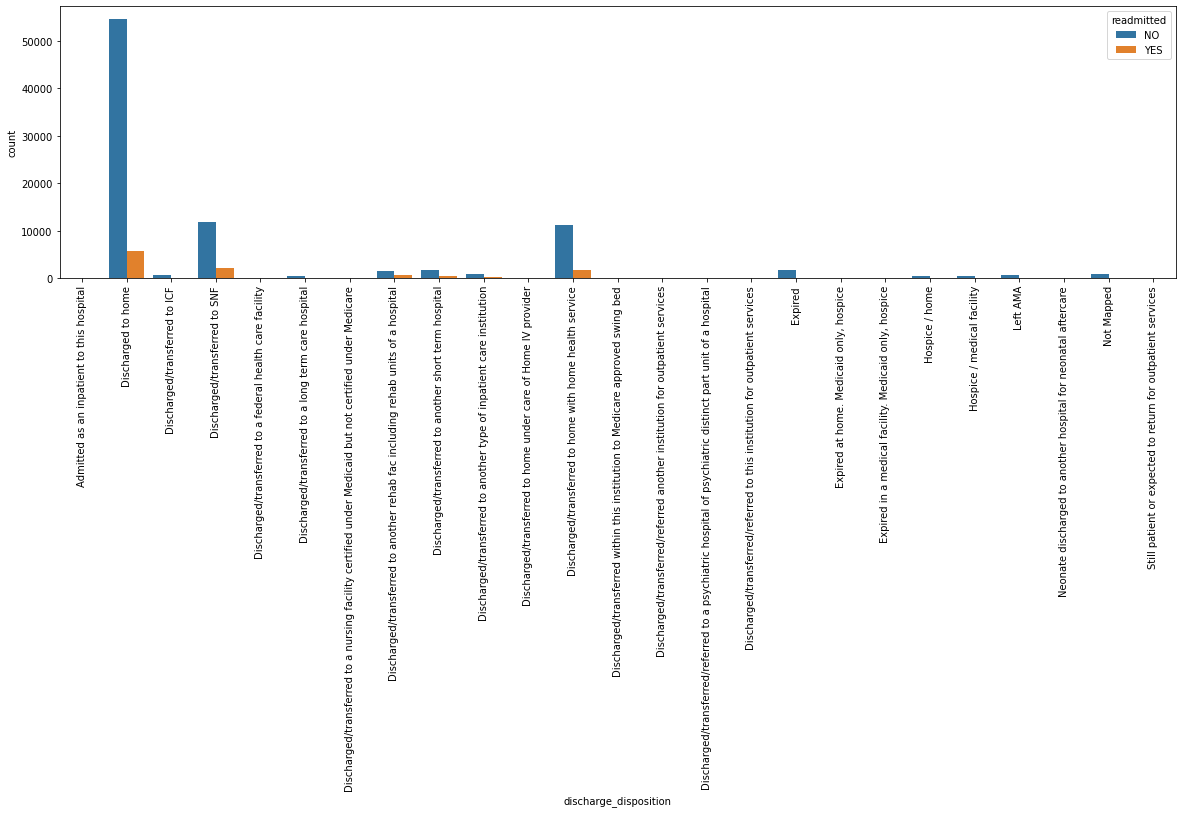

In [24]:
plt.figure(figsize=(20, 5))
chart = sns.countplot(x=df['discharge_disposition'], hue=df['readmitted'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
pass

Большинство пациентов на момент выписки были отправлены домой

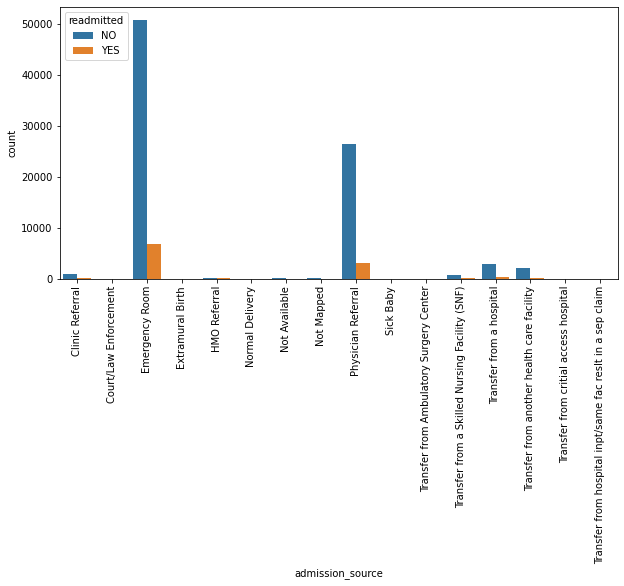

In [25]:
plt.figure(figsize=(10, 5))
chart = sns.countplot(x=df['admission_source'], hue=df['readmitted'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
pass

Многие пациенты поступали из отделения неотложки

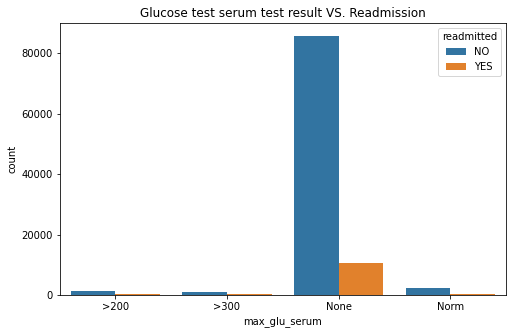

In [26]:
fig = plt.figure(figsize=(8, 5))
sns.countplot(x=df['max_glu_serum'], hue=df['readmitted']).set_title('Glucose test serum test result VS. Readmission')
pass

Подавлюящему большинству пациентов не делали тест на глюкозу

Text(0.5, 1.0, 'A1C test result VS. Readmission')

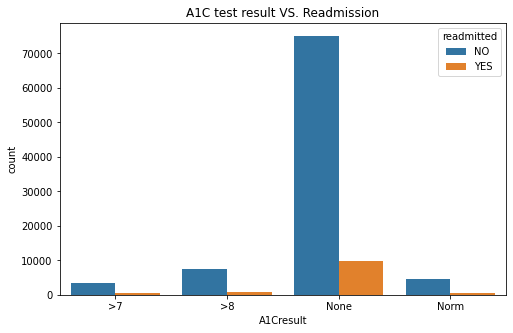

In [27]:
fig = plt.figure(figsize=(8, 5))
sns.countplot(x=df['A1Cresult'], hue=df['readmitted']).set_title('A1C test result VS. Readmission')

Снова такая же ситуация проявляется и с тестом на гемоглобин

Для того, чтобы получить матрицу корреляции и для числовых, и для категориальных признаков, произведем временную факторизацию категориальных данных

In [28]:
df_fact = df.copy()
for col in df_fact.select_dtypes(['category']):
    df_fact[col] = pd.factorize(df_fact[col])[0]

In [29]:
corr_mat = df_fact.corr(method='pearson')
corr_mat.style.background_gradient(cmap='coolwarm')

,race,gender,age,weight,admission_type,discharge_disposition,admission_source,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
race,1.000000,-0.033583,-0.140272,-0.054619,-0.053243,-0.028658,0.003431,-0.006538,0.012574,0.002744,0.007778,-0.024318,-0.058253,-0.033018,0.024550,0.010202,0.017456,0.004511,0.003335,-0.067019,-0.012672,0.038841,-0.000173,-0.004275,0.008304,-0.001505,-0.018949,-0.001235,-0.004440,-0.022418,-0.005926,-0.010632,-0.007847,-0.006961,-0.002957,-0.002140,-0.003102,0.020972,-0.000861,-0.004455,-0.001235,-0.007670,-0.001235,0.004377,-0.003879,-0.002093
gender,-0.033583,1.000000,-0.050535,0.010623,0.006646,-0.019734,-0.017714,-0.029928,0.034695,0.014953,-0.003103,0.059980,-0.022023,-0.011481,-0.021081,-0.014643,-0.015656,-0.008582,-0.016728,-0.003407,-0.001777,0.014975,0.003090,-0.005157,-0.005047,0.003878,-0.001171,-0.002907,0.022951,0.028235,0.000477,0.004799,0.013438,0.012629,0.008527,0.005853,0.007279,-0.000923,0.003447,0.006954,-0.002907,0.004779,-0.002907,0.014905,0.015901,-0.002939
age,-0.140272,-0.050535,1.000000,-0.007005,0.001330,0.132850,0.023228,0.107515,-0.180412,-0.046885,0.020770,-0.030104,0.041847,0.023724,-0.087291,-0.042861,-0.059949,-0.062124,-0.058892,0.242597,0.046616,-0.117017,-0.055400,0.049578,0.016791,0.012677,0.036186,0.001776,0.052888,0.076182,0.011801,0.012911,0.002754,0.008556,0.011236,-0.001465,0.005199,-0.081905,-0.001293,0.002042,-0.000190,0.002512,-0.000190,-0.036019,-0.022601,0.017634
weight,-0.054619,0.010623,-0.007005,1.000000,-0.030567,-0.015864,-0.001394,0.018773,0.032643,-0.038246,0.075806,0.012259,0.007255,0.085127,0.005503,-0.009270,-0.002529,0.033069,0.020492,0.044758,-0.032692,-0.019878,0.015335,-0.004012,0.007169,0.000370,0.007423,-0.000463,0.014109,0.007546,-0.000912,0.022340,-0.001474,0.004974,-0.002618,-0.000801,-0.000922,-0.066217,-0.012037,-0.001668,-0.000463,-0.000654,-0.000463,-0.034539,-0.026571,-0.002523
admission_type,-0.053243,0.006646,0.001330,-0.030567,1.000000,0.024666,-0.278199,-0.030338,0.044007,0.185197,-0.307261,0.114689,0.084065,0.061810,0.001738,-0.043576,0.031607,0.015855,0.011195,-0.047465,0.228200,-0.086639,0.029860,0.007025,0.000019,0.004233,0.006399,-0.001928,-0.006242,0.004237,0.008984,0.007476,0.020883,0.002780,0.001918,-0.004917,-0.004736,0.023676,0.016230,-0.002406,-0.001928,0.001137,0.003536,0.058241,0.034254,-0.013475
discharge_disposition,-0.028658,-0.019734,0.132850,-0.015864,0.024666,1.000000,-0.012004,0.133851,-0.008869,0.000277,0.034417,-0.013658,0.113407,0.018346,0.002683,0.028188,0.004350,0.021928,0.020968,0.116043,0.005534,-0.024213,-0.014551,0.009847,0.002954,-0.009170,0.001629,0.014849,0.002641,-0.015108,0.003027,0.006128,-0.000930,-0.002983,0.009015,-0.000194,-0.009269,0.038976,0.009034,0.001374,-0.001181,-0.000159,-0.000112,0.035717,0.019339,0.068120
admission_source,0.003431,-0.017714,0.023228,-0.001394,-0.278199,-0.012004,1.000000,0.060811,0.030930,-0.075583,0.158769,-0.043589,-0.057065,-0.075397,-0.016717,0.007384,-0.029678,-0.001092,-0.012278,-0.047441,-0.257989,0.053235,-0.023502,0.006950,-0.003525,0.005889,0.011598,0.000558,-0.008480,0.005591,-0.004187,-0.020946,-0.019097,-0.005067,0.001835,0.000966,0.003865,0.017638,-0.003425,-0.000271,0.000558,-0.001150,-0.002184,-0.037252,-0.000801,0.001953
time_in_hospital,-0.006538,-0.029928,0.107515,0.018773,-0.030338,0.133851,0.060811,1.000000,-0.066288,-0.001539,0.318450,0.191472,0.466135,-0.008916,-0.009681,0.073623,-0.003928,0.033012,0.024733,0.220186,0.004254,0.062148,0.007128,0.032422,0.007098,0

Отобразим матрицу в компактном и красивом виде

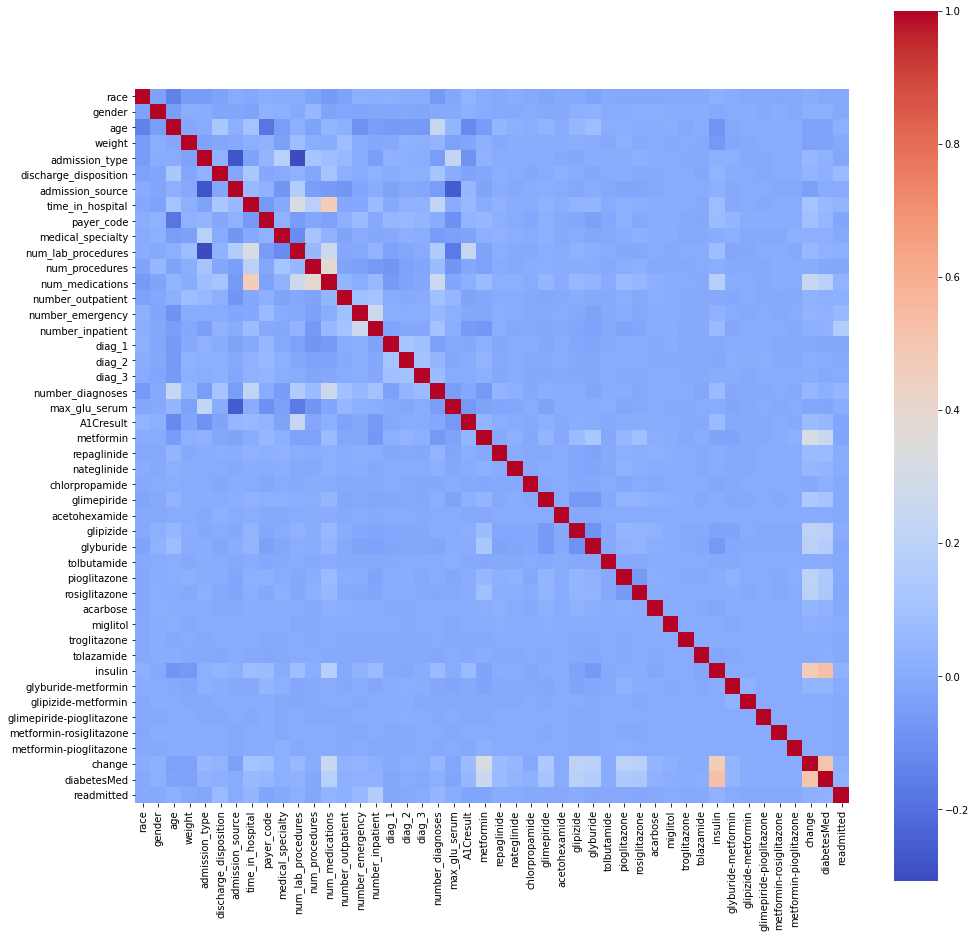

In [30]:
plt.figure(figsize=(16, 16))
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

А также выведем те пары признаков, имеющую большую корреляцию

In [31]:
corr_mat.where(np.triu((corr_mat > 0.4) | (corr_mat < -0.4), k=1)).stack().sort_values(ascending=False)

insulin           diabetesMed        0.528238
change            diabetesMed        0.506370
insulin           change             0.468226
time_in_hospital  num_medications    0.466135
dtype: float64

Сильно коррелированные признаки отсутствует, существуют небольшие корреляции между "insulin", "change" и "diabetesMed", а также между "time_in_hospital" и "num_medications", которые вполне объяснимы

# Пропущенные и некорректные значения

Посмотрим, много ли пропущенных значений содержится в данном датасете

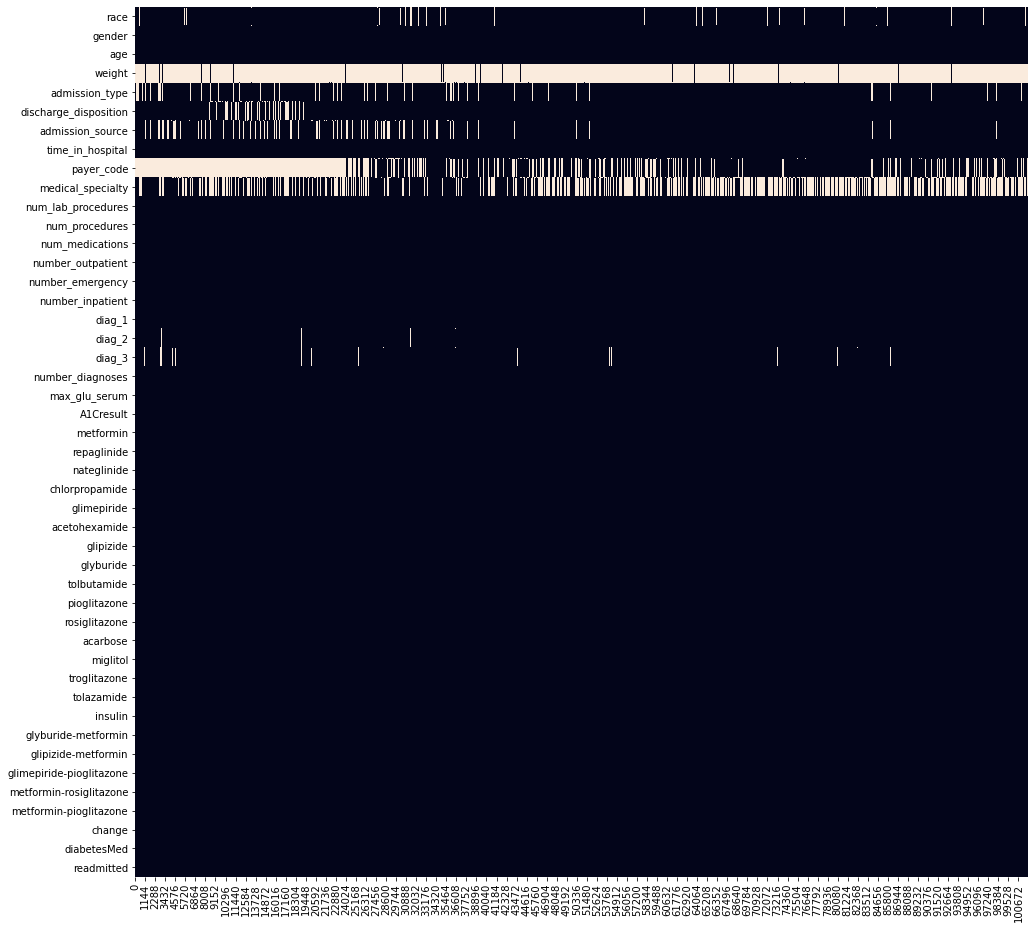

In [32]:
plt.figure(figsize=(16, 16))
sns.heatmap(df.isnull().T, cbar=False)
pass

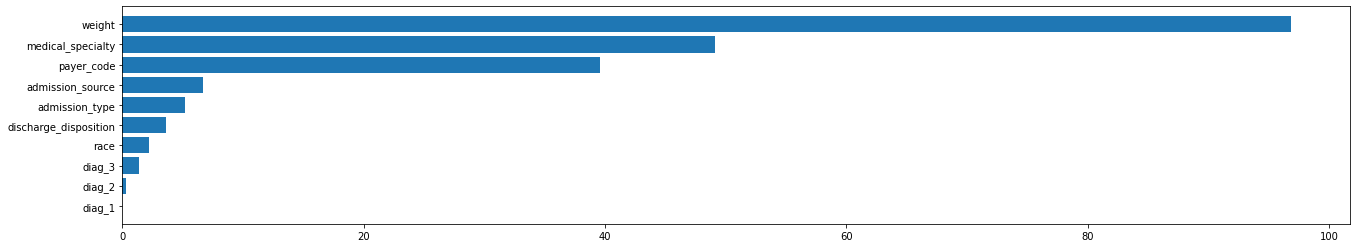

In [33]:
plt.figure(figsize=(22, 4))
missing = pd.DataFrame({'column': df.columns, 'na_percent': (df.isnull().sum() / len(df)) * 100})
missing = missing[missing['na_percent'] != 0]
missing.sort_values('na_percent', inplace=True)
plt.barh(missing['column'], width=missing['na_percent'])
pass

Мы видим, что есть признаки, в которых пропущено много значений, а есть те, где незначительно

In [34]:
missing['na_percent'].sort_values(ascending=False)

weight                   96.858479
medical_specialty        49.082208
payer_code               39.557416
admission_source          6.663326
admission_type            5.199182
discharge_disposition     3.626948
race                      2.233555
diag_3                    1.398306
diag_2                    0.351787
diag_1                    0.020636
Name: na_percent, dtype: float64

Также, изучим какие значения принимают категориальные признаки

In [35]:
for cat_col in df.select_dtypes('category').columns.values.tolist():
    print(cat_col, df[cat_col].unique().tolist())

race ['Caucasian', 'AfricanAmerican', nan, 'Other', 'Asian', 'Hispanic']
gender ['Female', 'Male', 'Unknown/Invalid']
age ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
weight [nan, '[75-100)', '[50-75)', '[0-25)', '[100-125)', '[25-50)', '[125-150)', '[175-200)', '[150-175)', '>200']
admission_type [nan, 'Emergency', 'Urgent', 'Elective', 'Newborn', 'Not Available', 'Not Mapped', 'Trauma Center']
discharge_disposition ['Not Mapped', 'Discharged to home', 'Discharged/transferred to SNF', 'Discharged/transferred to home with home health service', 'Discharged/transferred to another short term hospital', 'Discharged/transferred to another type of inpatient care institution', 'Expired', 'Left AMA', 'Neonate discharged to another hospital for neonatal aftercare', 'Discharged/transferred to ICF', 'Hospice / medical facility', nan, 'Discharged/transferred to home under care of Home IV provider', 'Hospice / home', 'Still patient o

Удалим следующее признаки, потому что мы не сможем их восстановить:

*   "wieght" - отсутствует почти у всех записей; до 2009 г. больницы и клиники не требовали фиксировать вес в стуктурированном формате
*   "payer_code" - отсутствует у почти 40% записей; не является релевантным


In [36]:
df.drop(['weight', 'payer_code'], axis=1, inplace=True)

Для следущих признаков заменим NaN'ы на значение 'Not Available' (данное значение специально выделено):

*   "admission_source"
*   "medical_specialty"
*   "admission_type"
*   "discharge_disposition"

In [37]:
df['admission_source'].fillna('Not Available', inplace=True)
df['admission_type'].fillna('Not Available', inplace=True)

df['medical_specialty'].cat.add_categories('Not Available', inplace=True)
df['medical_specialty'].fillna('Not Available', inplace=True)

df['discharge_disposition'].cat.add_categories('Not Available', inplace=True)
df['discharge_disposition'].fillna('Not Available', inplace=True)

Для остальных признаков, ввиду малости пропущенных значений, удалим те строки, содержащие NaN'ы:

*   "race"
*   "diag_3"
*   "diag_2"
*   "diag_1"

Возможно, диагнозы не были поставлены из-за сложности постановки конкретного диагноза (может быть диагноз не смогли установить или его не было)


In [38]:
df.dropna(subset=['race', 'diag_3', 'diag_2', 'diag_1'], inplace=True)

Можно заметить, что признак "gender" содержит значение 'Unknown/Invalid', посмотрим, много ли таких в таблице

In [39]:
len(df[df['gender'] == 'Unknown/Invalid'])

1

Можем попросту удалить эту строку

In [40]:
df.drop(df[df['gender'] == 'Unknown/Invalid'].index, axis=0, inplace=True)

Проверим, нет ли больше пропущенных значений

In [41]:
np.all(df.isnull().sum() == 0)

True

In [42]:
df.describe(include=['category'])

,race,gender,age,admission_type,discharge_disposition,admission_source,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052,98052
unique,5,2,10,7,26,16,73,713,740,786,4,4,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,4,4,2,2,1,2,2,2,2
top,Caucasian,Female,[70-80),Emergency,Discharged to home,Emergency Room,Not Available,428,428,250,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
freq,75079,52833,25305,52178,57609,55951,48318,6730,6517,11208,92844,81859,78807,96529,97361,97969,93065,98051,85769,87791,98030,90955,91886,97753,98015,98049,98015,45942,97383,98039,98051,98052,98051,52774,75350,86986


После проделанных операций заметим, что признак 'metformin-rosiglitazone' содержит только одно уникальное значение, поэтому удалим его

In [43]:
df.drop(['metformin-rosiglitazone'], axis=1, inplace=True)

Набор данных дает нам возраст только по 10-летней категории, поэтому мы не знаем точного возраста каждого пациента. Переведем этот признак в числовой, выбрав среднее значение интервала.

In [44]:
age = df['age'].copy()

for i in range(0,10):
    age = age.replace('['+str(10*i)+'-'+str(10*(i+1))+')', (10*i + (10*(i + 1))) // 2)
age = pd.to_numeric(age)

In [45]:
df = pd.concat([age, df.drop(['age'], axis=1)], axis=1)

In [46]:
df_numerics = df.select_dtypes(['int64'])

# Обработка категориальных признаков

## Категоризация болезней

Набор данных содержит до трех диагнозов для каждого пациента (первичный, вторичный и дополнительный). Однако у каждого из них 700–900 уникальных кодов МКБ9, что чрезвычайно сложно использовать в модели и интерпретировать.
Сгруппируем их в 9 категорий:

1.   Circulatory (кровеносная) [390–459, 785]
2.   Respiratory (респираторная) [460–519, 786]
3.   Digestive (пищеварительная) [520–579, 787]
4.   Diabetes (диабет) [250.xx]
5.   Injury (травма) [800–999]
6.   Musculoskeletal (скелетно-мышечная) [710–739]
7.   Genitourinary (мочеполовая) [580–629, 788]
8.   Neoplasms (новообразования) [140–239]
9.   Other (другие)





In [47]:
diagnoses = ['Circulatory', 'Respiratory', 'Digestive', 'Diabetes', 'Injury', 'Musculoskeletal', 'Genitourinary', 'Neoplasms', 'Other']
diag_cols = ['diag_1', 'diag_2', 'diag_3']

df_diag_cat = df[diag_cols].copy()
df_diag_cat['diag_1'].cat.add_categories(diagnoses, inplace=True)
df_diag_cat['diag_2'].cat.add_categories(diagnoses, inplace=True)
df_diag_cat['diag_3'].cat.add_categories(diagnoses, inplace=True)

In [48]:
def get_category_diag(code: str):
    if isinstance(code, float):
        return float('nan')

    if code.startswith('V') or code.startswith('E'):
        return 'Other'

    code = float(code)
    if 390 <= code <= 459 or code == 785:
        return 'Circulatory'
    if 460 <= code <= 519 or code == 786:
        return 'Respiratory'
    if 520 <= code <= 579 or code == 787:
        return 'Digestive'
    if int(code) == 250:
        return 'Diabetes'
    if 800 <= code <= 999:
        return 'Injury'
    if 710 <= code <= 739:
        return 'Musculoskeletal'
    if 580 <= code <= 629 or code == 788:
        return 'Genitourinary'
    if 140 <= code <= 239:
        return 'Neoplasms'
  
    return 'Other'

for index, row in df.iterrows():
    df_diag_cat.loc[index, 'diag_1'] = get_category_diag(df.loc[index, 'diag_1'])
    df_diag_cat.loc[index, 'diag_2'] = get_category_diag(df.loc[index, 'diag_2'])
    df_diag_cat.loc[index, 'diag_3'] = get_category_diag(df.loc[index, 'diag_3'])

In [49]:
df_diag_cat

,diag_1,diag_2,diag_3
1,Other,Diabetes,Other
2,Other,Diabetes,Other
3,Other,Diabetes,Circulatory
4,Neoplasms,Neoplasms,Diabetes
5,Circulatory,Circulatory,Diabetes
...,...,...,...
101761,Diabetes,Other,Circulatory
101762,Digestive,Other,Digestive
101763,Other,Genitourinary,Other
101764,Injury,Other,Injury


In [50]:
df_diag_cat['diag_3'].unique().tolist()

['Other',
 'Circulatory',
 'Diabetes',
 'Respiratory',
 'Injury',
 'Neoplasms',
 'Genitourinary',
 'Digestive',
 'Musculoskeletal']

In [51]:
df_diag_cat['diag_1'] = df_diag_cat['diag_1'].cat.remove_unused_categories()
df_diag_cat['diag_2'] = df_diag_cat['diag_2'].cat.remove_unused_categories()
df_diag_cat['diag_3'] = df_diag_cat['diag_3'].cat.remove_unused_categories()

In [52]:
df = pd.concat([df.drop(['diag_1', 'diag_2', 'diag_3'], axis=1), df_diag_cat], axis=1)

In [53]:
df.shape

(98052, 43)

## Обработка других категориальных признаков

Посмотрим сколько уникальных значений содержатся в каждом категориальном признаке, чтобы более рационально их кодировать

In [54]:
for col in df.select_dtypes(['category']):
    print(col, df[col].nunique())

race 5
gender 2
admission_type 7
discharge_disposition 26
admission_source 16
medical_specialty 73
max_glu_serum 4
A1Cresult 4
metformin 4
repaglinide 4
nateglinide 4
chlorpropamide 4
glimepiride 4
acetohexamide 2
glipizide 4
glyburide 4
tolbutamide 2
pioglitazone 4
rosiglitazone 4
acarbose 4
miglitol 4
troglitazone 2
tolazamide 3
insulin 4
glyburide-metformin 4
glipizide-metformin 2
glimepiride-pioglitazone 2
metformin-pioglitazone 2
change 2
diabetesMed 2
readmitted 2
diag_1 9
diag_2 9
diag_3 9


Для признаков, имеющих >= 10 уникальных значений, проведем Base-N кодирование, для тех; кто имеет только 2 значения - бинаризацию; для всех остальных - one-hot

In [55]:
import category_encoders as ce

encoder = ce.BaseNEncoder(base=3, drop_invariant=True)
medical_specialty = encoder.fit_transform(df['medical_specialty']) / 2
medical_specialty.info()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'pandas.core.frame.DataFrame'>
Int64Index: 98052 entries, 1 to 101765
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   medical_specialty_1  98052 non-null  float64
 1   medical_specialty_2  98052 non-null  float64
 2   medical_specialty_3  98052 non-null  float64
 3   medical_specialty_4  98052 non-null  float64
dtypes: float64(4)
memory usage: 3.7 MB


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [56]:
encoder = ce.BaseNEncoder(base=4, drop_invariant=True)
admission_source = encoder.fit_transform(df['admission_source']) / 3
admission_source.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98052 entries, 1 to 101765
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   admission_source_1  98052 non-null  float64
 1   admission_source_2  98052 non-null  float64
dtypes: float64(2)
memory usage: 2.2 MB


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [57]:
encoder = ce.BaseNEncoder(base=3, drop_invariant=True)
discharge_disposition = encoder.fit_transform(df['discharge_disposition']) / 2
discharge_disposition.info()

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


<class 'pandas.core.frame.DataFrame'>
Int64Index: 98052 entries, 1 to 101765
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   discharge_disposition_1  98052 non-null  float64
 1   discharge_disposition_2  98052 non-null  float64
 2   discharge_disposition_3  98052 non-null  float64
dtypes: float64(3)
memory usage: 3.0 MB


In [58]:
df = pd.concat([df.drop(['medical_specialty', 'admission_source', 'discharge_disposition'], axis=1), medical_specialty, admission_source, discharge_disposition], axis=1)

In [59]:
df['gender'] = pd.factorize(df['gender'])[0]
df['acetohexamide'] = pd.factorize(df['acetohexamide'])[0]
df['tolbutamide'] = pd.factorize(df['tolbutamide'])[0]
df['troglitazone'] = pd.factorize(df['acetohexamide'])[0]
df['tolazamide'] = pd.factorize(df['troglitazone'])[0]
df['glipizide-metformin'] = pd.factorize(df['glipizide-metformin'])[0]
df['metformin-pioglitazone'] = pd.factorize(df['metformin-pioglitazone'])[0]
df['change'] = pd.factorize(df['change'])[0]
df['diabetesMed'] = pd.factorize(df['diabetesMed'])[0]
df['readmitted'] = pd.factorize(df['readmitted'])[0]

In [60]:
for col in df.select_dtypes(['category']):
    df[col] = df[col].cat.remove_unused_categories()
    df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col)], axis=1)

In [61]:
df.shape

(98052, 129)

In [62]:
df.describe()

,age,gender,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,acetohexamide,tolbutamide,troglitazone,tolazamide,glipizide-metformin,metformin-pioglitazone,change,diabetesMed,readmitted,medical_specialty_1,medical_specialty_2,medical_specialty_3,medical_specialty_4,admission_source_1,admission_source_2,discharge_disposition_1,discharge_disposition_2,discharge_disposition_3,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,admission_type_Elective,admission_type_Emergency,admission_type_Newborn,admission_type_Not Available,admission_type_Not Mapped,admission_type_Trauma Center,admission_type_Urgent,...,miglitol_No,miglitol_Steady,miglitol_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glimepiride-pioglitazone_No,glimepiride-pioglitazone_Steady,diag_1_Circulatory,diag_1_Respiratory,diag_1_Digestive,diag_1_Diabetes,diag_1_Injury,diag_1_Musculoskeletal,diag_1_Genitourinary,diag_1_Neoplasms,diag_1_Other,diag_2_Circulatory,diag_2_Respiratory,diag_2_Digestive,diag_2_Diabetes,diag_2_Injury,diag_2_Musculoskeletal,diag_2_Genitourinary,diag_2_Neoplasms,diag_2_Other,diag_3_Circulatory,diag_3_Respiratory,diag_3_Digestive,diag_3_Diabetes,diag_3_Injury,diag_3_Musculoskeletal,diag_3_Genitourinary,diag_3_Neoplasms,diag_3_Other
count,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,...,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.00000,98052.000000,98052.000000,98052.000000
mean,66.260250,0.461174,4.422011,43.148462,1.350712,16.119590,0.376382,0.202464,0.646871,7.512096,0.000010,0.000224,0.000010,0.000010,0.000133,0.000010,0.538225,0.231530,0.112858,0.025741,0.089621,0.189338,0.508230,0.153038,0.267440,0.054012,0.136025,0.482203,0.192561,0.006374,0.765706,0.020234,0.015125,0.185544,0.532146,0.000102,0.099906,0.003182,0.000204,0.178915,...,0.999623,0.000316,0.000020,0.120783,0.468547,0.299515,0.111155,0.000031,0.993177,0.006731,0.000061,0.999990,0.000010,0.302176,0.142710,0.093695,0.081232,0.068362,0.048331,0.050820,0.033778,0.178895,0.317209,0.108483,0.041294,0.120977,0.023743,0.017440,0.083660,0.025425,0.261769,0.302197,0.073420,0.039285,0.170267,0.019275,0.01899,0.066567,0.018562,0.291437
std,15.590805,0.498493,2.993070,19.711757,1.708475,8.108496,1.283365,0.942897,1.271025,1.832472,0.003194,0.014977,0.003194,0.003194,0.011514,0.003194,0.498539,0.421813,0.316421,0.140318,0.214841,0.296337,0.316054,0.208006,0.213136,0.193966,0.257730,0.304368,0.394313,0.079584,0.423559,0.140801,0.122049,0.388741,0.498968,0.010098,0.299876,0.056320,0.014281,0.383283,...,0.019422,0.017778,0.004516,0.325876,0.499012,0.458048,0.314326,0.005531,0.082319,0.081767,0.007822,0.003194,0.003194,0.459204,0.349779,0.291406,0.273193,0.252367,0.214467,0.219631,0.180658,0.383266,0.465392,0.310991,0.198971,0.326102,0.152247,0.130904,0.276878,0.157414,0.439600,0.459212,0.260826,0.194274,0.375869,0.137492,0.13649,0.249271,0.134971,0.454427
min,5.000000,0.000000,1.000000,1.000000,0.000000,1.

# Нормализация количественных признаков

Перед применением алгоритмов машинного обучения данные полезно нормализовать, воспользуемся методом Z-score normalization 

In [63]:
df_numerics = (df_numerics - df_numerics.mean(axis=0)) / df_numerics.std(axis=0)

In [64]:
df_numerics.describe()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04
mean,-5.227011e-15,1.708714e-14,-1.887332e-14,2.946804e-16,-4.978657e-15,-4.825553e-14,-9.105167e-14,3.062017e-14,1.062674e-13
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.929255e+00,-1.143311e+00,-2.138240e+00,-7.905951e-01,-1.864660e+00,-2.932773e-01,-2.147255e-01,-5.089364e-01,-2.462300e+00
25%,-7.222366e-01,-8.092063e-01,-6.163054e-01,-7.905951e-01,-6.313859e-01,-2.932773e-01,-2.147255e-01,-5.089364e-01,-8.251672e-01
50%,-8.083288e-02,-1.409960e-01,4.319950e-02,-2.052777e-01,-1.380761e-01,-2.932773e-01,-2.147255e-01,-5.089364e-01,2.662548e-01
75%,5.605708e-01,5.272143e-01,7.027044e-01,3.800396e-01,4.785611e-01,-2.932773e-01,-2.147255e-01,2.778300e-01,8.119658e-01
max,1.843378e+00,3.200055e+00,4.507540e+00,2.721309e+00,8.001535e+00,3.243318e+01,8.038794e+01,1.601316e+01,4.631943e+00


In [65]:
df = pd.concat([df_numerics, df.drop(df_numerics, axis=1)], axis=1)

In [66]:
df.describe()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,gender,acetohexamide,tolbutamide,troglitazone,tolazamide,glipizide-metformin,metformin-pioglitazone,change,diabetesMed,readmitted,medical_specialty_1,medical_specialty_2,medical_specialty_3,medical_specialty_4,admission_source_1,admission_source_2,discharge_disposition_1,discharge_disposition_2,discharge_disposition_3,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,admission_type_Elective,admission_type_Emergency,admission_type_Newborn,admission_type_Not Available,admission_type_Not Mapped,admission_type_Trauma Center,admission_type_Urgent,...,miglitol_No,miglitol_Steady,miglitol_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glimepiride-pioglitazone_No,glimepiride-pioglitazone_Steady,diag_1_Circulatory,diag_1_Respiratory,diag_1_Digestive,diag_1_Diabetes,diag_1_Injury,diag_1_Musculoskeletal,diag_1_Genitourinary,diag_1_Neoplasms,diag_1_Other,diag_2_Circulatory,diag_2_Respiratory,diag_2_Digestive,diag_2_Diabetes,diag_2_Injury,diag_2_Musculoskeletal,diag_2_Genitourinary,diag_2_Neoplasms,diag_2_Other,diag_3_Circulatory,diag_3_Respiratory,diag_3_Digestive,diag_3_Diabetes,diag_3_Injury,diag_3_Musculoskeletal,diag_3_Genitourinary,diag_3_Neoplasms,diag_3_Other
count,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,...,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.00000,98052.000000,98052.000000,98052.000000
mean,-5.227011e-15,1.708714e-14,-1.887332e-14,2.946804e-16,-4.978657e-15,-4.825553e-14,-9.105167e-14,3.062017e-14,1.062674e-13,0.461174,0.000010,0.000224,0.000010,0.000010,0.000133,0.000010,0.538225,0.231530,0.112858,0.025741,0.089621,0.189338,0.508230,0.153038,0.267440,0.054012,0.136025,0.482203,0.192561,0.006374,0.765706,0.020234,0.015125,0.185544,0.532146,0.000102,0.099906,0.003182,0.000204,0.178915,...,0.999623,0.000316,0.000020,0.120783,0.468547,0.299515,0.111155,0.000031,0.993177,0.006731,0.000061,0.999990,0.000010,0.302176,0.142710,0.093695,0.081232,0.068362,0.048331,0.050820,0.033778,0.178895,0.317209,0.108483,0.041294,0.120977,0.023743,0.017440,0.083660,0.025425,0.261769,0.302197,0.073420,0.039285,0.170267,0.019275,0.01899,0.066567,0.018562,0.291437
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.498493,0.003194,0.014977,0.003194,0.003194,0.011514,0.003194,0.498539,0.421813,0.316421,0.140318,0.214841,0.296337,0.316054,0.208006,0.213136,0.193966,0.257730,0.304368,0.394313,0.079584,0.423559,0.140801,0.122049,0.388741,0.498968,0.010098,0.299876,0.056320,0.014281,0.383283,...,0.019422,0.017778,0.004516,0.325876,0.499012,0.458048,0.314326,0.005531,0.082319,0.081767,0.007822,0.003194,0.003194,0.459204,0.349779,0.291406,0.273193,0.252367,0.214467,0.219631,0.180658,0.383266,0.465392,0.310991,0.198971,0.326102,0.152247,0.130904,0.276878,0.157414,0.439600,0.459212,0.260826,0.194274,0.375869,0.137492,0.13649,0.2492

# Отбор признаков

In [67]:
x = df.drop(['readmitted'], axis=1)
y = df['readmitted']

x = np.array(x)
y = np.array(y)

Разобьем данные на обучающую и тестовую выборки в пропорции 3:1 (75% - обучающая выборка, 25% - тестовая):

In [68]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

print(x_train.shape, x_test.shape)

(73539, 128) (24513, 128)


# Обучение

In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## kNN

В ходе выполнения задания, я столкнулся с проблемой очень долгого обучения метода kNN. Facebook AI Research (FAIR) разработал отличные реализации алгоритмов поиска ближайшего соседа, которые доступны в библиотеке faiss. С его [помощью](https://towardsdatascience.com/make-knn-300-times-faster-than-scikit-learns-in-20-lines-5e29d74e76bb) мы можем реализовать классификатор ближайших соседей, который не только в несколько раз быстрее, чем Scikit-learn, но и на порядки быстрее!

In [70]:
import faiss


class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

Запустим метод kNN на разных значениях k и построим график зависимости ошибки на обучающей и контрольной выборке от числа ближайших соседей. Запуск делается с параметром кол-ва соседей от 1 до 51 с шагом 2.


In [71]:
from tqdm import tqdm

iter_ = range(1, 51, 2)

y_train_pred = []
y_test_pred = []

for k in tqdm(iter_):
    knn = FaissKNeighbors(k=k)
    knn.fit(x_train, y_train)

    y_train_pred.append(knn.predict(x_train))
    y_test_pred.append(knn.predict(x_test))

100%|██████████| 25/25 [22:31<00:00, 54.06s/it]


47


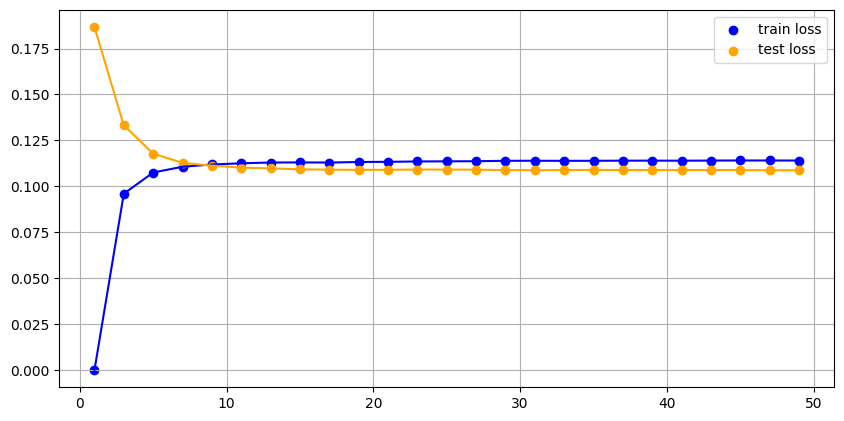

In [72]:
fig = plt.figure(figsize=(10, 5), dpi=100)

iter_ = range(1, 51, 2)

res_train = []
res_test = []

for i in range(len(iter_)):
    res_train.append(np.mean(y_train != y_train_pred[i]))
    res_test.append(np.mean(y_test != y_test_pred[i]))

plt.scatter(list(iter_)[::-1], res_train[::-1], color='blue', label='train loss')
plt.scatter(list(iter_)[::-1], res_test[::-1], color='orange', label='test loss')

plt.plot(list(iter_)[::-1], res_train[::-1], color='blue')
plt.plot(list(iter_)[::-1], res_test[::-1], color='orange')

plt.grid()
plt.legend()

best_k = int(np.argmin(res_test) * 2 + 1)
print(best_k)

In [73]:
knn = FaissKNeighbors(k=best_k)
knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)

In [75]:
print("Accuracy", accuracy_score(y_test, y_pred))
print("Precision", precision_score(y_test, y_pred))
print("Recall", recall_score(y_test, y_pred))
print("F1", f1_score(y_test, y_pred))
print("Error", np.mean(y_test != y_pred))

Accuracy 0.8912821768041448
Precision 0.6
Recall 0.007859281437125748
F1 0.01551533062430735
Error 0.10871782319585525



Было опробовано разное количество ближайших соседей для метода ближайщих соседей. Наилучашая точность была достигнута при 47 соседях, в этом случае ошибка составила около 10%. Дополнительно были посчитаны метрики (Accuracy, Precision, Recall, F1), из-за несбалансированности классов, Recall и F1 оказываются довольно низкими.

Далее были опробованы некоторые другие методы

## Logistic Regression

In [76]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='newton-cg')
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)

In [78]:
print("Accuracy", accuracy_score(y_test, y_pred))
print("Precision", precision_score(y_test, y_pred))
print("Recall", recall_score(y_test, y_pred))
print("F1", f1_score(y_test, y_pred))
print("Error", np.mean(y_test != y_pred))

Accuracy 0.8909558193611553
Precision 0.49504950495049505
Recall 0.0187125748502994
F1 0.036062026685899744
Error 0.10904418063884469


Logistic Resgeression практически не изменил результаты

## SGDClassifier

In [96]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train, y_train)

y_pred = sgd.predict(x_test)

In [97]:
print("Accuracy", accuracy_score(y_test, y_pred))
print("Precision", precision_score(y_test, y_pred))
print("Recall", recall_score(y_test, y_pred))
print("F1", f1_score(y_test, y_pred))
print("Error", np.mean(y_test != y_pred))

Accuracy 0.8910374087219026
Precision 0.5074626865671642
Recall 0.012724550898203593
F1 0.024826579043446515
Error 0.10896259127809733


Использование SGDClassifier также не улучшает результаты

## Desicion Tree

In [110]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(max_depth=28, criterion="entropy", random_state=42)
dtree.fit(x_train, y_train)

y_pred = dtree.predict(x_test)

In [111]:
print("Accuracy", accuracy_score(y_test, y_pred))
print("Precision", precision_score(y_test, y_pred))
print("Recall", recall_score(y_test, y_pred))
print("F1", f1_score(y_test, y_pred))
print("Error", np.mean(y_test != y_pred))

Accuracy 0.8246644637539264
Precision 0.16570723684210525
Recall 0.15082335329341318
F1 0.1579153605015674
Error 0.1753355362460735


Использование DecisionTreeClassifier ухудшило ошибку, Accuray и Precision, но немного улучшило Recall и F1

# Борьба с несбалансированностью классов

Восстановление баланса классов может проходить двумя путями. В первом случае удаляют некоторое количество примеров мажоритарного класса (undersampling), во втором – увеличивают количество примеров миноритарного (oversampling).
В нашем случае применим метод SMOTE для искусственной генерации данных с меткой минорантного класса, а после - уберем часть данных мажорантного класса

In [117]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.8)

x_train_smote, y_train_smote = over.fit_sample(x_train, y_train)
x_bal, y_bal = under.fit_sample(x_train_smote, y_train_smote)

print('Original dataset shape {}'.format(Counter(y_train)))
print('New dataset shape {}'.format(Counter(y_bal)))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Original dataset shape Counter({0: 65145, 1: 8394})
New dataset shape Counter({0: 16286, 1: 13029})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [118]:
from tqdm import tqdm

iter_ = range(1, 51, 2)

y_train_pred = []
y_test_pred = []

for k in tqdm(iter_):
    knn = FaissKNeighbors(k=k)
    knn.fit(x_bal, y_bal)

    y_train_pred.append(knn.predict(x_bal))
    y_test_pred.append(knn.predict(x_test))


100%|██████████| 25/25 [05:03<00:00, 12.13s/it]


1


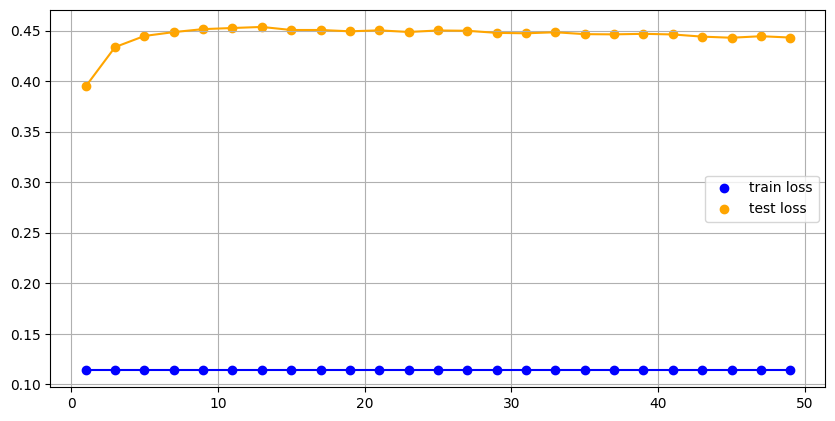

In [119]:
fig = plt.figure(figsize=(10, 5), dpi=100)

iter_ = range(1, 51, 2)

res_train = []
res_test = []

for i in range(len(iter_)):
    res_train.append(np.mean(y_train != y_bal[i]))
    res_test.append(np.mean(y_test != y_test_pred[i]))

plt.scatter(list(iter_)[::-1], res_train[::-1], color='blue', label='train loss')
plt.scatter(list(iter_)[::-1], res_test[::-1], color='orange', label='test loss')

plt.plot(list(iter_)[::-1], res_train[::-1], color='blue')
plt.plot(list(iter_)[::-1], res_test[::-1], color='orange')

plt.grid()
plt.legend()

best_k = int(np.argmin(res_test) * 2 + 1)
print(best_k)

In [120]:
knn = FaissKNeighbors(k=best_k)
knn.fit(x_bal, y_bal)

y_pred = knn.predict(x_test)

In [121]:
print("Accuracy", accuracy_score(y_test, y_pred))
print("Precision", precision_score(y_test, y_pred))
print("Recall", recall_score(y_test, y_pred))
print("F1", f1_score(y_test, y_pred))
print("Error", np.mean(y_test != y_pred))

Accuracy 0.6052706727042794
Precision 0.12537441163885324
Recall 0.43862275449101795
F1 0.1950083194675541
Error 0.39472932729572063


Использование метода kNN к новым данным не помогло улучшить ситуацию. Посмотрим другие методы

In [126]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='newton-cg')
lr.fit(x_bal, y_bal)

y_pred = lr.predict(x_test)

In [127]:
print("Accuracy", accuracy_score(y_test, y_pred))
print("Precision", precision_score(y_test, y_pred))
print("Recall", recall_score(y_test, y_pred))
print("F1", f1_score(y_test, y_pred))
print("Error", np.mean(y_test != y_pred))

Accuracy 0.7596377432382817
Precision 0.18966846569005397
Recall 0.36826347305389223
F1 0.250381679389313
Error 0.24036225676171827


Применение LogisticRegression позволило улучшить ошибку по сравнению с методом kNN

In [128]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_bal, y_bal)

y_pred = sgd.predict(x_test)

In [129]:
print("Accuracy", accuracy_score(y_test, y_pred))
print("Precision", precision_score(y_test, y_pred))
print("Recall", recall_score(y_test, y_pred))
print("F1", f1_score(y_test, y_pred))
print("Error", np.mean(y_test != y_pred))

Accuracy 0.6380695957247174
Precision 0.15934065934065933
Recall 0.5426646706586826
F1 0.24634726469588852
Error 0.3619304042752825


Применение SGDClassifier немного улучшает ошибку по сравнению с kNN

In [130]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(max_depth=28, criterion="entropy", random_state=42)
dtree.fit(x_bal, y_bal)

y_pred = dtree.predict(x_test)

In [131]:
print("Accuracy", accuracy_score(y_test, y_pred))
print("Precision", precision_score(y_test, y_pred))
print("Recall", recall_score(y_test, y_pred))
print("F1", f1_score(y_test, y_pred))
print("Error", np.mean(y_test != y_pred))

Accuracy 0.6665850773059193
Precision 0.1420018222048679
Recall 0.4083083832335329
F1 0.21071945919845486
Error 0.3334149226940807


Применение DecisionTreeClassifier немного улучшает ошибку по сравнению с SGDClassifier

# Выводы (часть 1)

1. В данном датасете отсутствует сильная корреляция признаков и целевой метки
2. Обработаны пропущенные и некорректные значения
3. Изначальная задача сведена к задаче бинарной классификации
4. Были опробованы методы kNN, Logistic Regression, SGDClassifier, Decision Tree
4. Наилучшим методом оказался метод kNN с 47 соседями, ошибка была около 10%
5. Несмотря на то, что значение Accuracy было хорошим (около 90%), из-за несбалансированности классов модель имеет перевес в сторону мажорантного класса (об этом, к примеру, свидетельствует неудовлетворительно низкое значение F1 меры)
6. Была предпринята попытка борьбы с несбалансированностью классов - к сожалению, она не привела к улучшению результатов

# PCA & LDA

Применение LDA позволяет сократить размерность максимум до min(nClasses-1, nFeatures), в нашем случае это 1-мерное пространство

In [132]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=1)
x_lda = lda.fit_transform(x, y)

y_pd = y.reshape(y.shape[0], 1)
data = np.concatenate([x_lda, y_pd], axis=1)

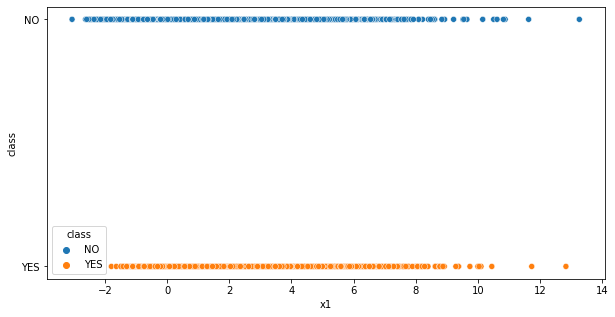

In [136]:
plt.figure(figsize=(10, 5))

df = pd.DataFrame(data=data, columns=["x1", 'class'])
df.loc[df['class'] == 0, 'class'] = 'NO'
df.loc[df['class'] == 1, 'class'] = 'YES'
sns.scatterplot(data=df, x="x1", y="class", hue="class")
pass

Очевидно, что классы на картинке не разделимы

С помощью метода главных компонент найдем 2 главные компоненты

In [137]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

y_pd = y.reshape(y.shape[0], 1)
data = np.concatenate([x_pca, y_pd], axis=1)

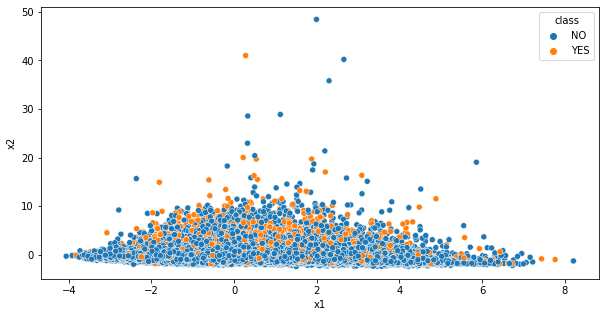

In [139]:
plt.figure(figsize=(10, 5))

df = pd.DataFrame(data=data, columns=["x1", 'x2', 'class'])
df.loc[df['class'] == 0, 'class'] = 'NO'
df.loc[df['class'] == 1, 'class'] = 'YES'

sns.scatterplot(data=df, x="x1", y="x2", hue="class")
pass

Из графика очевидно, что визуально классы не разделимы

Для понижения размерности данных будет использоваться метод главных компонент со всеми возможными количествами главных компонент. Был организован перебор с сохранением данных для всех количеств компонент от 1 до 128 включительно. Будем использовать метод kNN с 47 соседями.

In [145]:
err_train = []
err_test = []

for i in tqdm(range(1, 128)):
    pca = PCA(n_components=i)
    pca.fit(x_train)

    x_train_pca = pca.transform(x_train)
    x_test_pca = pca.transform(x_test)
    
    knn = FaissKNeighbors(k=47)
    knn.fit(x_train_pca, y_train)
    
    у_pred_train = knn.predict(x_train_pca)
    у_pred_test = knn.predict(x_test_pca)
    
    err_train.append(np.mean(y_train != у_pred_train))
    err_test.append(np.mean(y_test != у_pred_test))


100%|██████████| 127/127 [1:33:10<00:00, 44.02s/it]


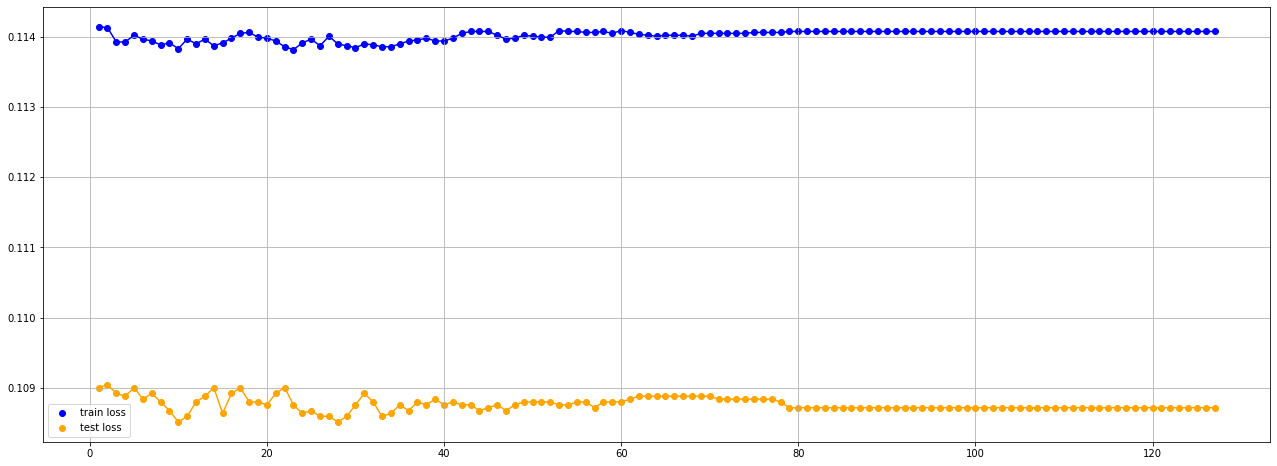

In [148]:
plt.figure(figsize=(22, 8))

plt.scatter(range(1, 128), err_train, label='train loss', color='blue')
plt.scatter(range(1, 128), err_test, label='test loss', color='orange')

plt.plot(range(1, 128), err_train, color='blue')
plt.plot(range(1, 128), err_test, color='orange')
plt.legend()
plt.grid()

In [151]:
best_comp_pca = int(np.argmin(err_test))
print(best_comp_pca, err_test[9])

9 0.10851384979398686


С числом компонент - 9, достигается минимум

In [152]:
pca = PCA(n_components=9)
pca.fit(x_train)

x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

knn = FaissKNeighbors(k=47)
knn.fit(x_train_pca, y_train)

y_pred = knn.predict(x_test_pca)

In [153]:
print("Accuracy", accuracy_score(y_test, y_pred))
print("Precision", precision_score(y_test, y_pred))
print("Recall", recall_score(y_test, y_pred))
print("F1", f1_score(y_test, y_pred))
print("Error", np.mean(y_test != y_pred))

Accuracy 0.8913637661648921
Precision 0.6097560975609756
Recall 0.0093562874251497
F1 0.01842978252856616
Error 0.1086362338351079


При использовании PCA не получилось существенно улучшить результаты, однако получилось существенно уменьшить размерность признаков

# Выводы (часть 2)

1.   Применение LDA не позволяет визуально разделить классы
2.   Применение PCA (до 2-х компонент) также не разделяет классы
3.   Применение PCA (до 9-х компонент) не улучшает результат, однако позволяет добиться существенного снижения размерности признаков


